In [1]:
from sklearn.model_selection import train_test_split
import shap

In [2]:
import lime 
import sklearn
import numpy as np
import sklearn.ensemble
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


## Dataset

In [16]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=7)
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state=7)

## Model Training & SHAP

In [12]:
def shap_model(X, y, parameters):
    clf_rf = RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)
    clf_rf.set_params(**parameters)
    clf_rf.fit(X, y)
    explainer = shap.TreeExplainer(clf_rf, X)
    shap_values = explainer.shap_values(X)
    return shap_values

### Original

In [13]:
rfc=RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)
param_distribution = { 
    'n_estimators': [200, 400, 600, 800, 1000],
    'min_samples_split': [2, 5, 10],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 4]
}

rscv_rf = RandomizedSearchCV(
    estimator = rfc, 
    param_distributions = param_distribution, 
    cv= 5,
    scoring='f1',
    n_jobs=-1).fit(X_train, y_train)

clf_rf_rs_origin = rscv_rf.best_estimator_
params_origin = rscv_rf.best_params_
print(params_origin)

{'n_estimators': 800, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10}


Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


F1 Score for best model: 0.650
Accuracy for best model: 0.860


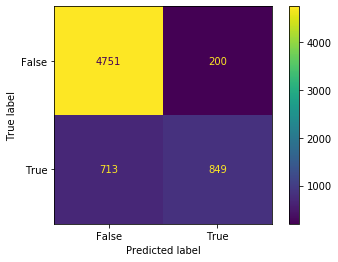

In [15]:
y_pred = clf_rf_rs_origin.predict(X_test)
sklearn.metrics.plot_confusion_matrix(clf_rf_rs_origin, X_test, y_test)
print("F1 Score for best model:", "{0:.3f}".format(sklearn.metrics.f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(sklearn.metrics.accuracy_score(y_test,y_pred)))

### Drop sex

In [17]:
features = list(X_train.columns)
features.remove('Sex')
X_train_dropsex = X_train[features]
X_test_dropsex = X_test[features]

In [18]:
rfc=RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)
param_distribution = { 
    'n_estimators': [200, 400, 600, 800, 1000],
    'min_samples_split': [2, 5, 10],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 4]
}

rscv_rf = RandomizedSearchCV(
    estimator = rfc, 
    param_distributions = param_distribution, 
    cv= 5,
    scoring='f1',
    n_jobs=-1).fit(X_train_dropsex, y_train)

clf_rf_rs = rscv_rf.best_estimator_
rscv_rf.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 14}

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


F1 Score for best model: 0.662
Accuracy for best model: 0.861


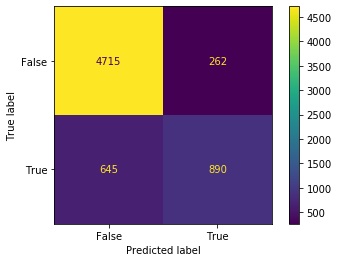

In [19]:
y_pred = clf_rf_rs.predict(X_test_dropsex)
sklearn.metrics.plot_confusion_matrix(clf_rf_rs, X_test_dropsex, y_test)
print("F1 Score for best model:", "{0:.3f}".format(sklearn.metrics.f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(sklearn.metrics.accuracy_score(y_test,y_pred)))

In [20]:
shap_values_dropsex = shap_model(X_train_dropsex, y_train, rscv_rf.best_params_)

100%|===================| 13019/13024 [42:46<00:00]        

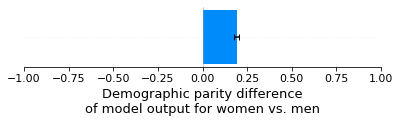

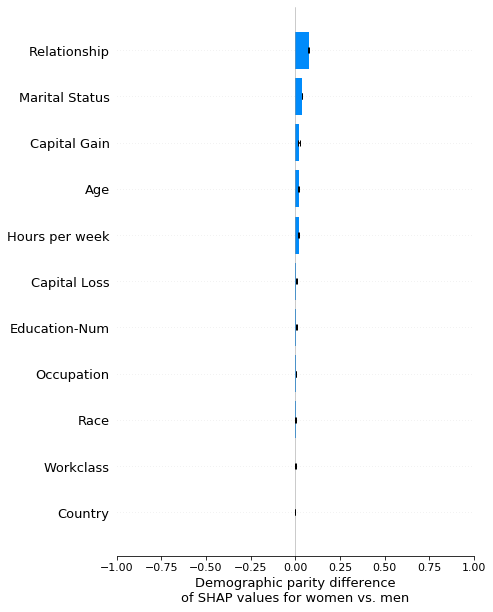

In [49]:
xmin = -1
xmax = 1
glabel = "Demographic parity difference\nof model output for women vs. men"
shap.group_difference_plot(shap_values_dropsex[1].sum(1), X_train['Sex']==1, xmin=xmin, xmax=xmax, xlabel=glabel)

slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values_dropsex[1], X_train['Sex']==1, X_train_dropsex.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

### Drop sex capital_loss

In [29]:
features = list(X_train.columns)
features.remove('Sex')
features.remove('Relationship')
X_train_dropsexcl = X_train[features]
X_test_dropsexcl = X_test[features]

In [30]:
rfc=RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)
param_distribution = { 
    'n_estimators': [200, 400, 600, 800, 1000],
    'min_samples_split': [2, 5, 10],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 4]
}

rscv_rf = RandomizedSearchCV(
    estimator = rfc, 
    param_distributions = param_distribution, 
    cv= 5,
    scoring='f1',
    n_jobs=-1).fit(X_train_dropsexcl, y_train)

clf_rf_rs_dscl = rscv_rf.best_estimator_
params_dscl = rscv_rf.best_params_

In [33]:
params_dscl

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 10}

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


F1 Score for best model: 0.626
Accuracy for best model: 0.855


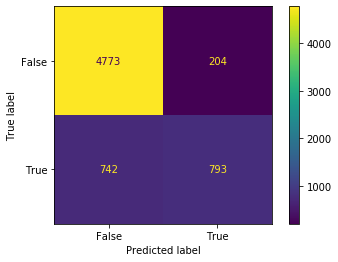

In [34]:
y_pred = clf_rf_rs_dscl.predict(X_test_dropsexcl)
sklearn.metrics.plot_confusion_matrix(clf_rf_rs_dscl, X_test_dropsexcl, y_test)
print("F1 Score for best model:", "{0:.3f}".format(sklearn.metrics.f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(sklearn.metrics.accuracy_score(y_test,y_pred)))

In [35]:
shap_values_dropsexcl = shap_model(X_train_dropsexcl, y_train, params_dscl)
# shap_values_dropsexcl = shap_values_dropsex

100%|===================| 13010/13024 [07:34<00:00]        

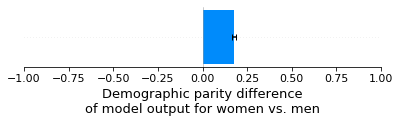

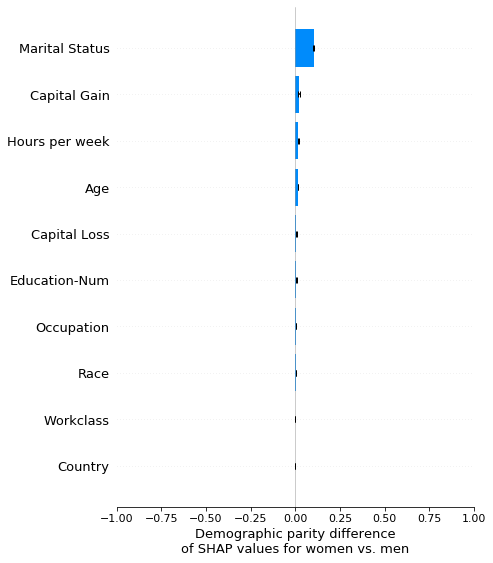

In [50]:
xmin = -1
xmax = 1
glabel = "Demographic parity difference\nof model output for women vs. men"
shap.group_difference_plot(shap_values_dropsexcl[1].sum(1),  X_train['Sex']==1, xmin=xmin, xmax=xmax, xlabel=glabel)

slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values_dropsexcl[1],  X_train['Sex']==1, X_train_dropsexcl.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

### Drop sex, capital loss, relationship

In [37]:
features = list(X_train.columns)
features.remove('Sex')
features.remove('Marital Status')
features.remove('Relationship')
X_train_dropsexclr = X_train[features]
X_test_dropsexclr = X_test[features]

In [38]:
rfc=RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)
param_distribution = { 
    'n_estimators': [200, 400, 600, 800, 1000],
    'min_samples_split': [2, 5, 10],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 4]
}

rscv_rf = RandomizedSearchCV(
    estimator = rfc, 
    param_distributions = param_distribution, 
    cv= 5,
    scoring='f1',
    n_jobs=-1).fit(X_train_dropsexclr, y_train)

clf_rf_rs_dsclr = rscv_rf.best_estimator_
params_dsclr = rscv_rf.best_params_
print(params_dsclr)

{'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 12}


In [39]:
params_dsclr

{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_depth': 12}

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


F1 Score for best model: 0.573
Accuracy for best model: 0.840


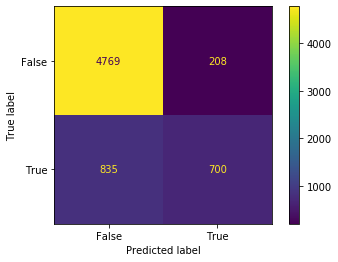

In [40]:
y_pred = clf_rf_rs_dsclr.predict(X_test_dropsexclr)
sklearn.metrics.plot_confusion_matrix(clf_rf_rs_dsclr, X_test_dropsexclr, y_test)
print("F1 Score for best model:", "{0:.3f}".format(sklearn.metrics.f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(sklearn.metrics.accuracy_score(y_test,y_pred)))

In [41]:
shap_values_dropsexclr = shap_model(X_train_dropsexclr, y_train, params_dsclr)

100%|===================| 13017/13024 [27:01<00:00]        

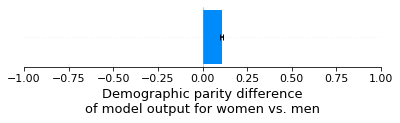

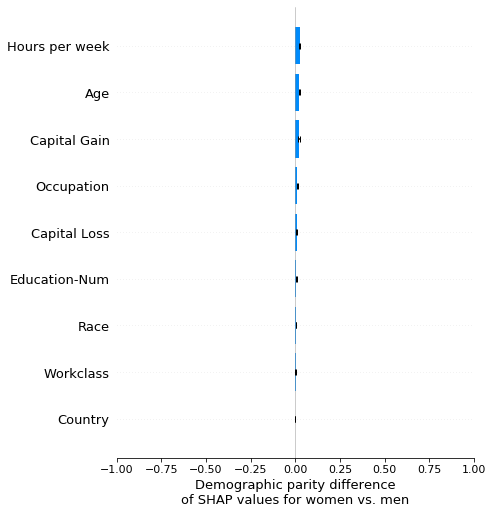

In [51]:
xmin = -1
xmax = 1
glabel = "Demographic parity difference\nof model output for women vs. men"
shap.group_difference_plot(shap_values_dropsexclr[1].sum(1), X_train['Sex']==1, xmin=xmin, xmax=xmax, xlabel=glabel)

slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values_dropsexclr[1], X_train['Sex']==1, X_train_dropsexclr.columns, xmin=xmin, xmax=xmax, xlabel=slabel)

### Drop sex, capital loss, relationship, Marital Status

In [43]:
features = list(X_train.columns)
features.remove('Sex')
features.remove('Marital Status')
features.remove('Relationship')
features.remove('Hours per week')
X_train_dropsexclrm = X_train[features]
X_test_dropsexclrm = X_test[features]

In [44]:
rfc=RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True)
param_distribution = { 
    'n_estimators': [200, 400, 600, 800, 1000],
    'min_samples_split': [2, 5, 10],
    'max_depth' : [2, 4, 6, 8, 10, 12, 14],
    'min_samples_leaf': [1, 2, 4]
}

rscv_rf = RandomizedSearchCV(
    estimator = rfc, 
    param_distributions = param_distribution, 
    cv= 5,
    scoring='f1',
    n_jobs=-1).fit(X_train_dropsexclrm, y_train)

clf_rf_rs_dsclrm = rscv_rf.best_estimator_
params_dsclrm = rscv_rf.best_params_
print(params_dsclrm)

{'n_estimators': 600, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 12}


In [45]:
params_dsclrm

{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_depth': 12}

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


F1 Score for best model: 0.566
Accuracy for best model: 0.841


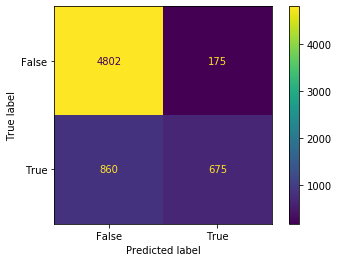

In [46]:
y_pred = clf_rf_rs_dsclrm.predict(X_test_dropsexclrm)
sklearn.metrics.plot_confusion_matrix(clf_rf_rs_dsclrm, X_test_dropsexclrm, y_test)
print("F1 Score for best model:", "{0:.3f}".format(sklearn.metrics.f1_score(y_test,y_pred)))
print("Accuracy for best model:", "{0:.3f}".format(sklearn.metrics.accuracy_score(y_test,y_pred)))

In [47]:
shap_values_dropsexclrm = shap_model(X_train_dropsexclrm, y_train, params_dsclrm)

100%|===================| 13015/13024 [12:16<00:00]        

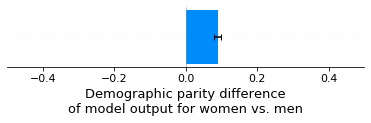

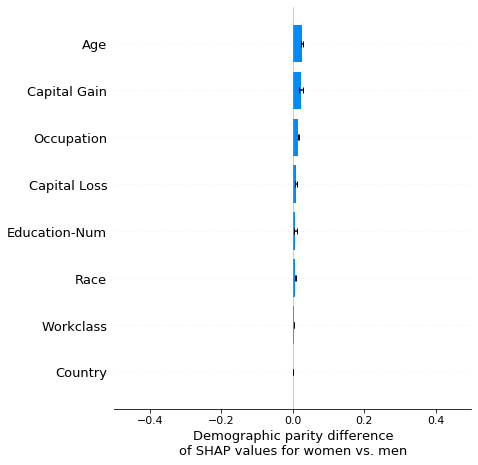

In [48]:
xmin = -0.5
xmax = 0.5
glabel = "Demographic parity difference\nof model output for women vs. men"
shap.group_difference_plot(shap_values_dropsexclrm[1].sum(1), X_train['Sex']==1, xmin=xmin, xmax=xmax, xlabel=glabel)

slabel = "Demographic parity difference\nof SHAP values for women vs. men"
shap.group_difference_plot(shap_values_dropsexclrm[1], X_train['Sex']==1, X_train_dropsexclrm.columns, xmin=xmin, xmax=xmax, xlabel=slabel)